In [16]:
import lightgbm
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import random
import os

# 시드 고정 함수
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
    lightgbm.seed = seed

set_seed(42)

In [17]:
import warnings

warnings.filterwarnings('ignore')

import pandas as pd

data = pd.read_csv('/Users/baby_cow/Desktop/AI/ML_competition/data/geocoded_addresses_12.csv')
data.columns

Index(['Unnamed: 0', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '거래유형', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
       'k-135㎡초과', '건축면적', '주차대수', 'target', 'is_test', 'latitude',
       'longitude', 'address', 'address_apt', 'address_apt_sqm', '구', '동',
       '강남여부', 'mean_target', 'apt_mean_target', 'address_mean_target',
       'mean_target_gu_dong', 'closest_bus_stop_distance',
       'closest_subway_station_distance', 'bus_stop_count_500m',
       'subway_station_count_500m', 'bus_stop_count_750m',
       'subway_station_count_750m', 'bus_stop_count_1000m',
       'subway_station_count_1000m', 'square_meter',
       'monthly_mean_target_rate', 'adjusted_square_meter', 'is_outlier',
       'year', 'month', 'distance_to_lead_house'],
      dtype='object')

In [18]:
temp_index = list(range(len(data)))
data['id'] = temp_index
selected_columns = ['id', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '구', '동', '건축년도','주차대수', '강남여부',
                    'closest_bus_stop_distance','closest_subway_station_distance', 'bus_stop_count_500m',
                    'subway_station_count_500m', 'bus_stop_count_750m',
                    'subway_station_count_750m', 'bus_stop_count_1000m',
                    'subway_station_count_1000m', 'distance_to_lead_house', 'is_test', 'target', 'apt_mean_target', 'mean_target']

df = data[selected_columns]

df['전용면적'] = df['전용면적(㎡)']
df.drop(columns=['전용면적(㎡)'], axis=1, inplace=True)

df['계약년'] = df['계약년월'].map(lambda x : int(str(x)[:4]))

df.head()

,id,아파트명,계약년월,계약일,층,구,동,건축년도,주차대수,강남여부,...,subway_station_count_750m,bus_stop_count_1000m,subway_station_count_1000m,distance_to_lead_house,is_test,target,apt_mean_target,mean_target,전용면적,계약년
0,0,개포6차우성,2017-12-01,8,3,강남구,개포동,1987,262.0,1,...,0,57,0,6.609733,0,124000.0,104403.465347,119240.517241,79.97,2017
1,1,개포6차우성,2017-12-01,22,4,강남구,개포동,1987,262.0,1,...,0,57,0,6.609733,0,123500.0,104403.465347,119240.517241,79.97,2017
2,2,개포6차우성,2017-12-01,28,5,강남구,개포동,1987,262.0,1,...,0,57,0,6.609733,0,91500.0,104403.465347,86362.500000,54.98,2017
3,3,개포6차우성,2018-01-01,3,4,강남구,개포동,1987,262.0,1,...,0,57,0,6.609733,0,130000.0,104403.465347,119240.517241,79.97,2018
4,4,개포6차우성,2018-01-01,8,2,강남구,개포동,1987,262.0,1,...,0,57,0,6.609733,0,117000.0,104403.465347,119240.517241,79.97,2018


# 지역별 chunk 나누기

In [19]:
chunks = {}

regions = df['구'].unique()

for region in regions:
    chunk = df[df['구'] == region]
    chunk.sort_values(by='계약년월')
    chunks[region] = chunk

# 모델 학습

In [30]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

result_board = []
result = pd.DataFrame()
trained_models = {}

params = {
    'objective': 'regression', 
    'metric': 'rmse',           
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'lambda_l2' : 0.1,
    'drop_rate' : 0.2,
    'verbose' : -1
}

for region in tqdm(regions):
    chunk = chunks[region]

    select_cols = ['id','층', '건축년도','주차대수',
        'closest_bus_stop_distance', 'closest_subway_station_distance',
        'bus_stop_count_500m', 'subway_station_count_500m',
        'bus_stop_count_750m', 'subway_station_count_750m',
        'bus_stop_count_1000m', 'subway_station_count_1000m',
        'distance_to_lead_house', 'is_test', 'target', '전용면적', '계약년',
        '올해 지역 평균', '작년 지역 평균', 'apt_mean_target', 'mean_target']
    
    chunk = chunk[select_cols]

    train_chunk = chunk.query('is_test == 0')
    test_chunk = chunk.query('is_test == 1')

    train_chunk.drop(columns=['is_test', 'id'], axis=1, inplace = True)
    test_chunk.drop(columns = ['is_test'], axis = 1, inplace = True)

    X = train_chunk.drop(columns=['target'], axis=1)
    y = train_chunk['target']

    tscv = TimeSeriesSplit(n_splits = 17)
    
    min_rmse = int(1e9)

    model = None
    for fold, (train_index, val_index) in enumerate(tscv.split(X), 1):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        train_data = lgb.Dataset(X_train, label = y_train)
        val_data = lgb.Dataset(X_val, label = y_val, reference = train_data)

        if model :
            model = lgb.train(
                params,
                train_data,
                num_boost_round=5000,
                init_model = model,
                valid_sets = [train_data, val_data],
                callbacks = [lgb.early_stopping(stopping_rounds=5), lgb.log_evaluation(period=-1)],
            )
        else:
            model = lgb.train(
                params,
                train_data,
                num_boost_round=5000,
                valid_sets = [train_data, val_data],
                callbacks = [lgb.early_stopping(stopping_rounds=5), lgb.log_evaluation(period=-1)],
            )
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        min_rmse = min(min_rmse, rmse)

    result_board.append({"지역" : region, "validation RMSE" : min_rmse})

    final_train_data = lgb.Dataset(X, label=y)
    final_model = lgb.train(params,
                            final_train_data,
                            init_model = model,
                            num_boost_round=model.best_iteration,
                            callbacks = [lgb.log_evaluation(period=-1)],
                            )
    
    trained_models[region] = final_model

    test_X = test_chunk.drop(columns=['id', 'target'], axis=1)
    pred = final_model.predict(test_X)

    test_chunk['target'] = pred

    result = pd.concat([result, test_chunk[['id', 'target']]]) 


  0%|          | 0/25 [00:00<?, ?it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[45]	training's rmse: 11818.7	valid_1's rmse: 36588.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[70]	training's rmse: 11736.2	valid_1's rmse: 16453.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[100]	training's rmse: 10580.5	valid_1's rmse: 15584.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[109]	training's rmse: 10994.9	valid_1's rmse: 74234.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[118]	training's rmse: 19456.3	valid_1's rmse: 34256.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[161]	training's rmse: 14518.4	valid_1's rmse: 24092.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[162]	t

  4%|▍         | 1/25 [00:08<03:26,  8.61s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[20]	training's rmse: 5843.48	valid_1's rmse: 14610.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[54]	training's rmse: 4399.94	valid_1's rmse: 7370.18
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[87]	training's rmse: 3682.42	valid_1's rmse: 8395.28
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[103]	training's rmse: 3839.57	valid_1's rmse: 26704.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[203]	training's rmse: 4191.2	valid_1's rmse: 12442
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[212]	training's rmse: 5477.73	valid_1's rmse: 13303.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[223]	train

  8%|▊         | 2/25 [00:17<03:20,  8.73s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[45]	training's rmse: 2810.46	valid_1's rmse: 4963.54
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[94]	training's rmse: 2510.05	valid_1's rmse: 7522.67
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[135]	training's rmse: 2267.12	valid_1's rmse: 10813.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[184]	training's rmse: 2346.07	valid_1's rmse: 16665
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[192]	training's rmse: 4263.16	valid_1's rmse: 7982.66
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[193]	training's rmse: 4822.55	valid_1's rmse: 6161.06
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[204]	tra

 12%|█▏        | 3/25 [00:21<02:23,  6.54s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[43]	training's rmse: 3988.46	valid_1's rmse: 8240.82
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[56]	training's rmse: 4144.5	valid_1's rmse: 6924.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[107]	training's rmse: 3394.43	valid_1's rmse: 14051.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[144]	training's rmse: 3682.8	valid_1's rmse: 12159
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[234]	training's rmse: 4062.76	valid_1's rmse: 10227
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[259]	training's rmse: 4362.92	valid_1's rmse: 7750.96
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[320]	training

 16%|█▌        | 4/25 [00:33<03:02,  8.67s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[30]	training's rmse: 3358.94	valid_1's rmse: 6589.31
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[67]	training's rmse: 2872.01	valid_1's rmse: 4341.77
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[101]	training's rmse: 2710.43	valid_1's rmse: 15260.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[137]	training's rmse: 2986.17	valid_1's rmse: 10996.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[254]	training's rmse: 3167.52	valid_1's rmse: 9808.71
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[291]	training's rmse: 3440.97	valid_1's rmse: 6920.69
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[302]	t

 20%|██        | 5/25 [00:41<02:49,  8.49s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[26]	training's rmse: 6273.98	valid_1's rmse: 16954.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[52]	training's rmse: 5877.37	valid_1's rmse: 8853.47
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[149]	training's rmse: 4459.36	valid_1's rmse: 10641.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[189]	training's rmse: 5513.56	valid_1's rmse: 44433.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[235]	training's rmse: 6132.09	valid_1's rmse: 15677.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[245]	training's rmse: 7088.25	valid_1's rmse: 17323.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[246]	t

 24%|██▍       | 6/25 [00:48<02:31,  8.00s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[64]	training's rmse: 2339.59	valid_1's rmse: 8049.96
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[102]	training's rmse: 2829.87	valid_1's rmse: 3994.11
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[107]	training's rmse: 2931.06	valid_1's rmse: 17633.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[126]	training's rmse: 3420.2	valid_1's rmse: 7492.12
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[222]	training's rmse: 2938.52	valid_1's rmse: 10000.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[246]	training's rmse: 3375.23	valid_1's rmse: 7747.28
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[287]	t

 28%|██▊       | 7/25 [00:57<02:30,  8.34s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[62]	training's rmse: 1942.74	valid_1's rmse: 5661.62
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[78]	training's rmse: 1974.3	valid_1's rmse: 3290.59
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[92]	training's rmse: 1862.09	valid_1's rmse: 21841.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[117]	training's rmse: 2887.72	valid_1's rmse: 6935.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[186]	training's rmse: 2567.22	valid_1's rmse: 9886.61
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[204]	training's rmse: 3047.79	valid_1's rmse: 8508.97
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[219]	trai

 32%|███▏      | 8/25 [01:02<02:03,  7.28s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[61]	training's rmse: 2217.29	valid_1's rmse: 6543.82
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[96]	training's rmse: 2386.74	valid_1's rmse: 3277.77
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[114]	training's rmse: 2324.92	valid_1's rmse: 18648.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[132]	training's rmse: 3284.16	valid_1's rmse: 7801.05
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[285]	training's rmse: 2947.69	valid_1's rmse: 9853.05
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[317]	training's rmse: 3092.18	valid_1's rmse: 9532.03
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[319]	t

In [ ]:
def bigsize_model(chunk):
    train_chunk = chunk.query('is_test == 0')
    test_chunk = chunk.query('is_test == 1')

    train_chunk.drop(columns=['is_test', 'id'], axis=1, inplace = True)
    test_chunk.drop(columns = ['is_test'], axis = 1, inplace = True)

    X = train_chunk.drop(columns=['target'], axis=1)
    y = train_chunk['target']
    
    tscv = TimeSeriesSplit(n_splits = 17)

    params = {
        'objective': 'regression', 
        'metric': 'rmse',           
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.1,
        'feature_fraction': 0.9,
        'lambda_l2' : 0.1,
        'drop_rate' : 0.2,
        'verbose' : -1
    }
    
    model = None
    for fold, (train_index, val_index) in enumerate(tscv.split(X), 1):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        train_data = lgb.Dataset(X_train, label = y_train)
        val_data = lgb.Dataset(X_val, label = y_val, reference = train_data)

        if model :
            model = lgb.train(
                params,
                train_data,
                num_boost_round=5000,
                init_model = model,
                valid_sets = [train_data, val_data],
                callbacks = [lgb.early_stopping(stopping_rounds=5), lgb.log_evaluation(period=-1)],
            )
        else:
            model = lgb.train(
                params,
                train_data,
                num_boost_round=5000,
                valid_sets = [train_data, val_data],
                callbacks = [lgb.early_stopping(stopping_rounds=5), lgb.log_evaluation(period=-1)],
            )
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        min_rmse = min(min_rmse, rmse)


# 결과 확인

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'  # MacOS의 기본 한글 폰트
plt.rcParams['axes.unicode_minus'] = False   # 마이너스 기호 깨짐 방지

3928.0232809110153


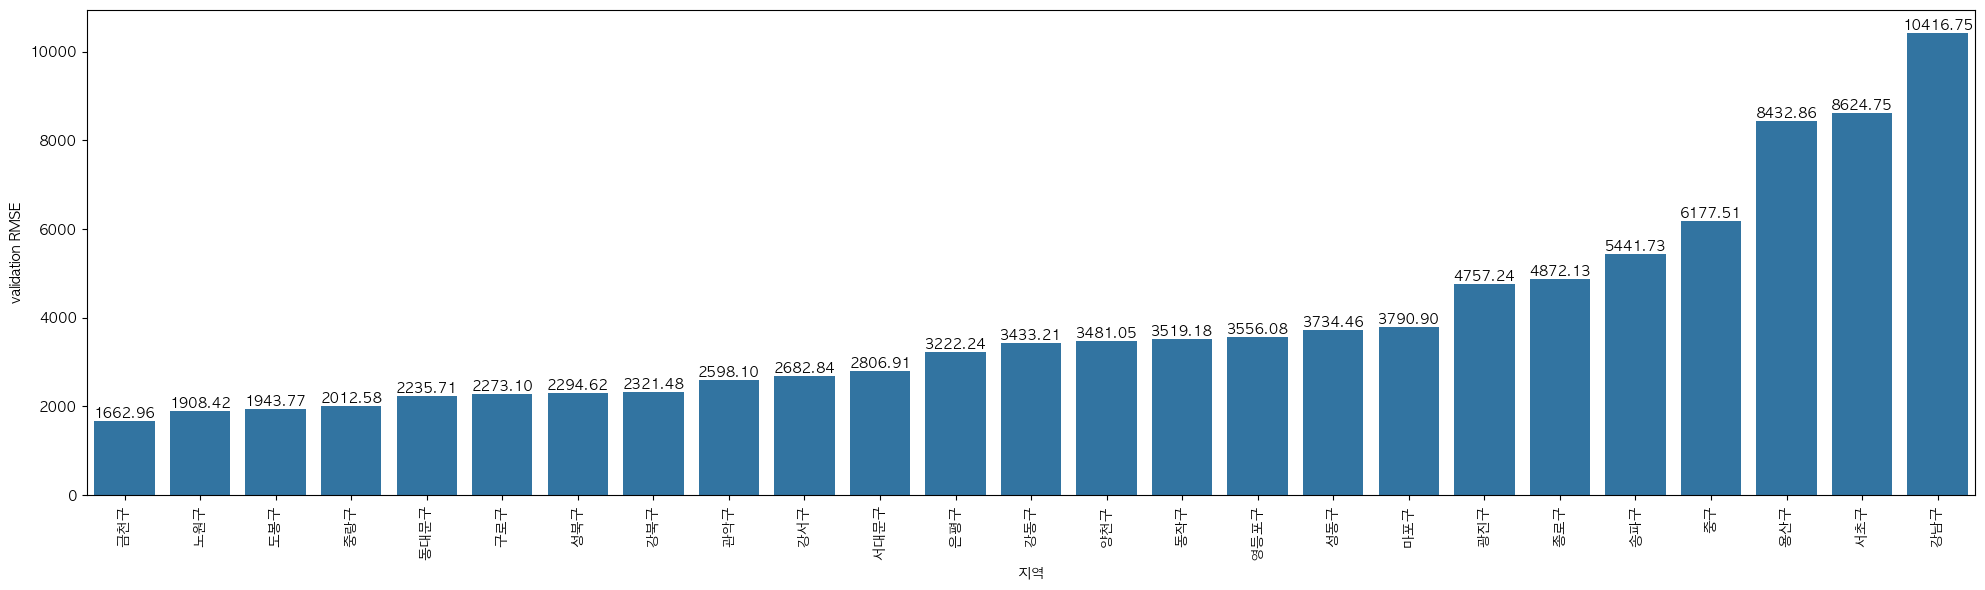

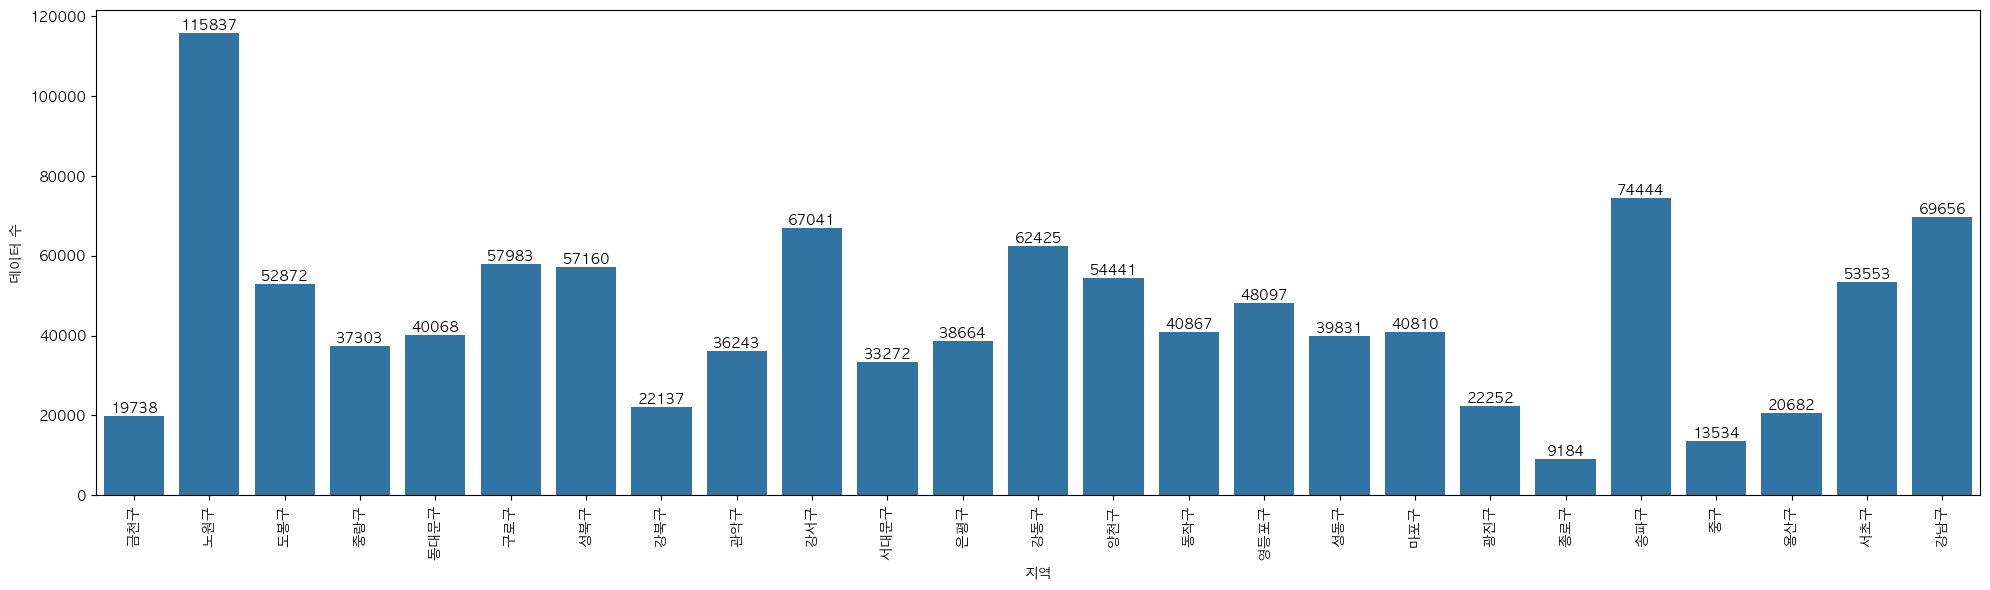

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

result_df = pd.DataFrame(result_board)
result_df = result_df.sort_values(by='validation RMSE')
result_df = result_df[-30:]

print(result_df['validation RMSE'].mean())

# 그래프 생성
plt.figure(figsize=(20, 6))
ax = sns.barplot(data=result_df, x='지역', y='validation RMSE')

# 바 위에 값 표시
for i, v in enumerate(result_df['validation RMSE']):
    ax.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()


temp_list = [{"지역" : region, "데이터 수" : len(chunks[region])} for region in result_df['지역']]
temp_df = pd.DataFrame(temp_list)

plt.figure(figsize=(20, 6))
ax = sns.barplot(data = temp_df, x='지역', y='데이터 수')

# 바 위에 값 표시
for i, v in enumerate(temp_df['데이터 수']):
    ax.text(i, v, f'{v}', ha='center', va='bottom')

plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

In [29]:
submit = result.sort_values(by = 'id')

display(submit)
print(submit.isnull().sum())

submit['target'] = submit['target'] * 1.065
submit['target'] = submit['target'].astype(int)
submit.to_csv('region_devision_parking_log_transform.csv', index=False)

,id,target
1118822,1118822,185160.248429
1118823,1118823,261470.654174
1118824,1118824,315943.806913
1118825,1118825,257243.247038
1118826,1118826,201417.042186
...,...,...
1128089,1128089,71672.063064
1128090,1128090,71023.609462
1128091,1128091,79982.455097
1128092,1128092,68662.774017


id        0
target    0
dtype: int64


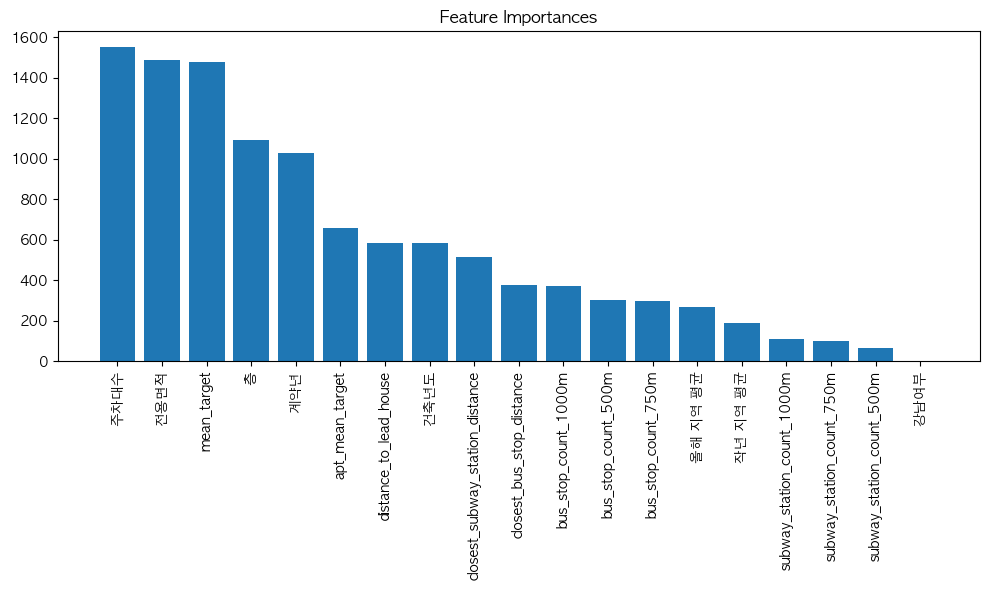

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# 특성 중요도와 특성 이름 가져오기
importances = model.feature_importance()

feature_names = X.columns  # X는 특성 데이터프레임

# 중요도에 따라 특성 정렬
indices = np.argsort(importances)[::-1]

# 시각화
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

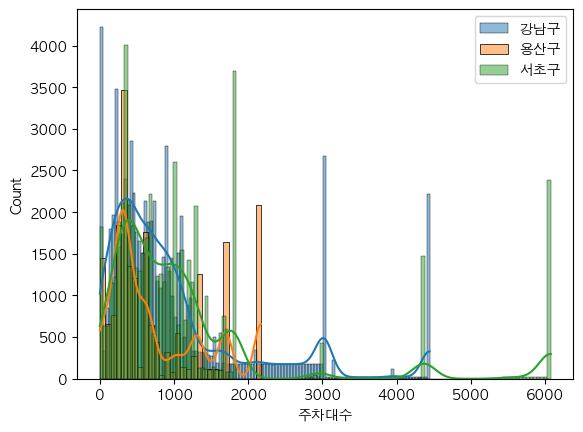

In [14]:
caution_regions = ['강남구', '용산구', '서초구']

for region in caution_regions:
    sns.histplot(data=chunks[region], x='주차대수', kde=True, label = region)
plt.legend()

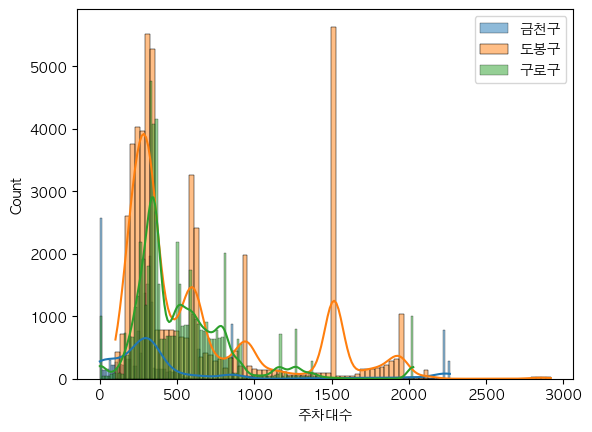

In [15]:
good_regions = ['금천구', '도봉구', '구로구']

for region in good_regions:
    sns.histplot(data=chunks[region], x='주차대수', kde=True, label = region)
plt.legend()